In [48]:
import pandas as pd

RESULT_DIR = "/mnt/d/Indago"
ALGOS = ["poison", "haircut", "seniority"]
VARIANTS = ["combined", "tornado", "known_addresses"]

In [49]:
known_addresses = pd.read_csv(f'{RESULT_DIR}/known-addresses.csv')

flagged: pd.DataFrame = known_addresses[known_addresses.legitimacy == 0]
print(f'found {len(flagged)} addresses flagged as illegitimate.')
pre_flagged = len(flagged)

found 5204 addresses flagged as illegitimate.


In [50]:
def get_file_paths(algo, variant) -> tuple[str, str]:
    result_file = f'{RESULT_DIR}/{algo}/{algo}-addresses-{variant}.{"txt" if algo == "poison" else "csv"}'
    rundata_file = f'{RESULT_DIR}/{algo}/{algo}-rundata-{variant}.csv'
    return result_file, rundata_file

def get_rundata(algo, variant) -> pd.DataFrame:
    _, rundata_file = get_file_paths(algo, variant)
    df = pd.read_csv(rundata_file)
    df['algorithm'] = algo
    df['variant'] = variant
    df['title'] = f'{algo.capitalize()} ({variant.replace("_", " ").capitalize() if variant != "known_addresses" else "Flagged"})'
    return df

In [51]:
rundata = pd.concat([get_rundata(algo, variant) for algo in ALGOS for variant in VARIANTS if variant != "combined"]).reset_index(drop=True)
rundata = rundata[rundata.current_block != 0]
rundata.tail()

,rows_processed,n_blacklisted,processed_after_mins,current_block,ram_usage_gb,algorithm,variant,title,n_blacklisted_0_01,n_blacklisted_0_1,n_blacklisted_1,n_blacklisted_10,n_blacklisted_100
1050,1710000000,29438749,80.42,19106911,28.76,seniority,known_addresses,Seniority (Flagged),25029382.0,3753923.0,518660.0,112422.0,15500.0
1051,1720000000,29462435,80.92,19171519,28.80,seniority,known_addresses,Seniority (Flagged),25063542.0,3748364.0,514190.0,112029.0,15447.0
1052,1730000000,29497702,81.42,19239834,28.85,seniority,known_addresses,Seniority (Flagged),25099649.0,3749587.0,512801.0,111431.0,15373.0
1053,1740000000,29531481,81.90,19305601,28.90,seniority,known_addresses,Seniority (Flagged),25133185.0,3752062.0,511227.0,110841.0,15305.0
1054,1750000000,29585309,82.38,19367750,28.95,seniority,known_addresses,Seniority (Flagged),25175909.0,3765386.0,509889.0,110058.0,15209.0


[Text(0.5, 1.0, 'Addresses blacklisted over time'),
 Text(0.5, 0, 'Block number'),
 Text(0, 0.5, '# of addresses blacklisted')]

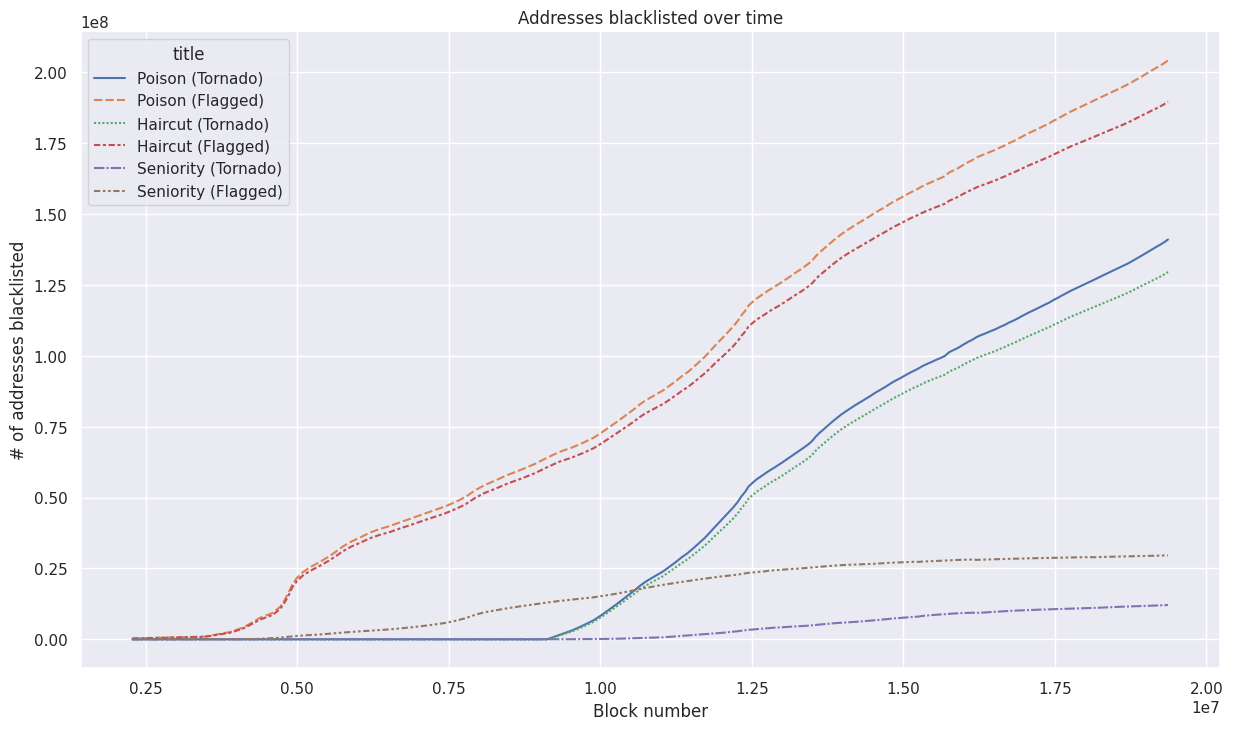

In [52]:
import seaborn as sns

# Create a visualization
sns.set_style("whitegrid")
sns.set_theme(rc={'figure.figsize': (14.7, 8.27)})
sns.lineplot(x='current_block', y='n_blacklisted', hue='title', style='title',
             data=rundata).set(title='Addresses blacklisted over time', xlabel='Block number', ylabel='# of addresses blacklisted')

[Text(0.5, 1.0, 'RAM usage over time'),
 Text(0.5, 0, 'Block number'),
 Text(0, 0.5, 'RAM used (GB)')]

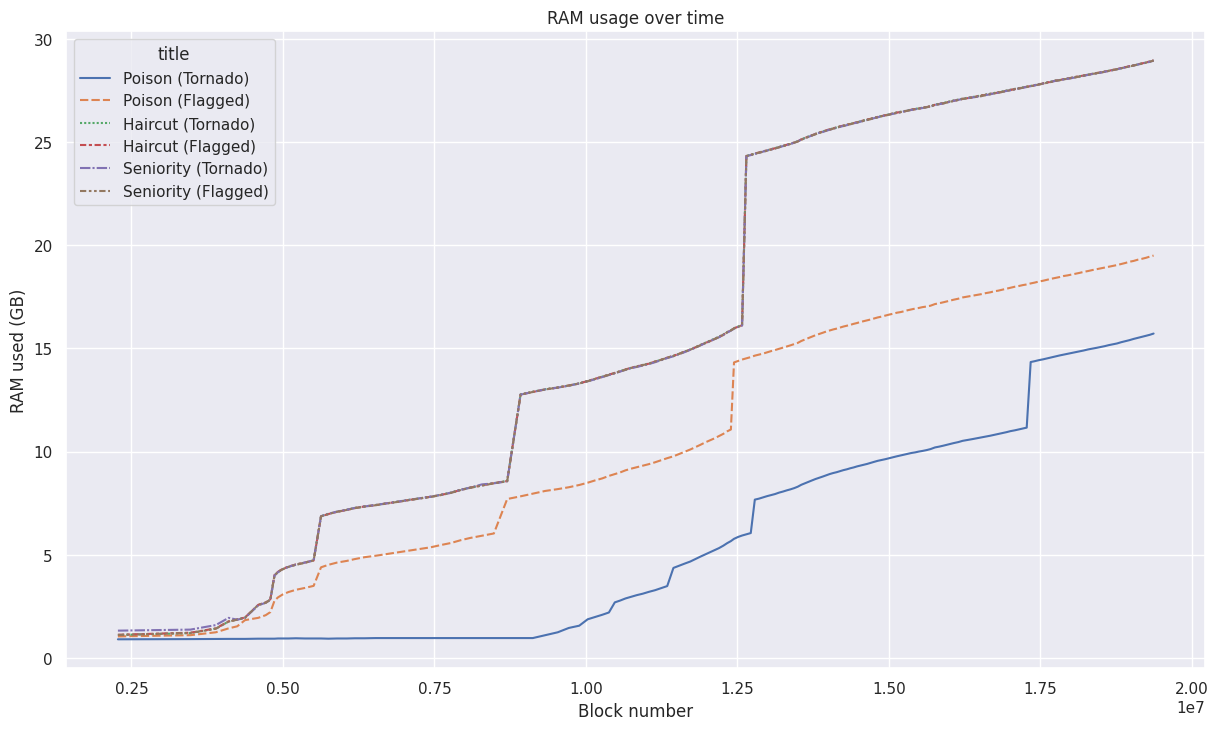

In [53]:
sns.lineplot(x='current_block', y='ram_usage_gb', hue='title', style='title',
             data=rundata).set(title='RAM usage over time', xlabel='Block number', ylabel='RAM used (GB)')

[Text(0.5, 1.0, 'Time to reach block'),
 Text(0.5, 0, 'Block number'),
 Text(0, 0.5, 'Processed after (minutes)')]

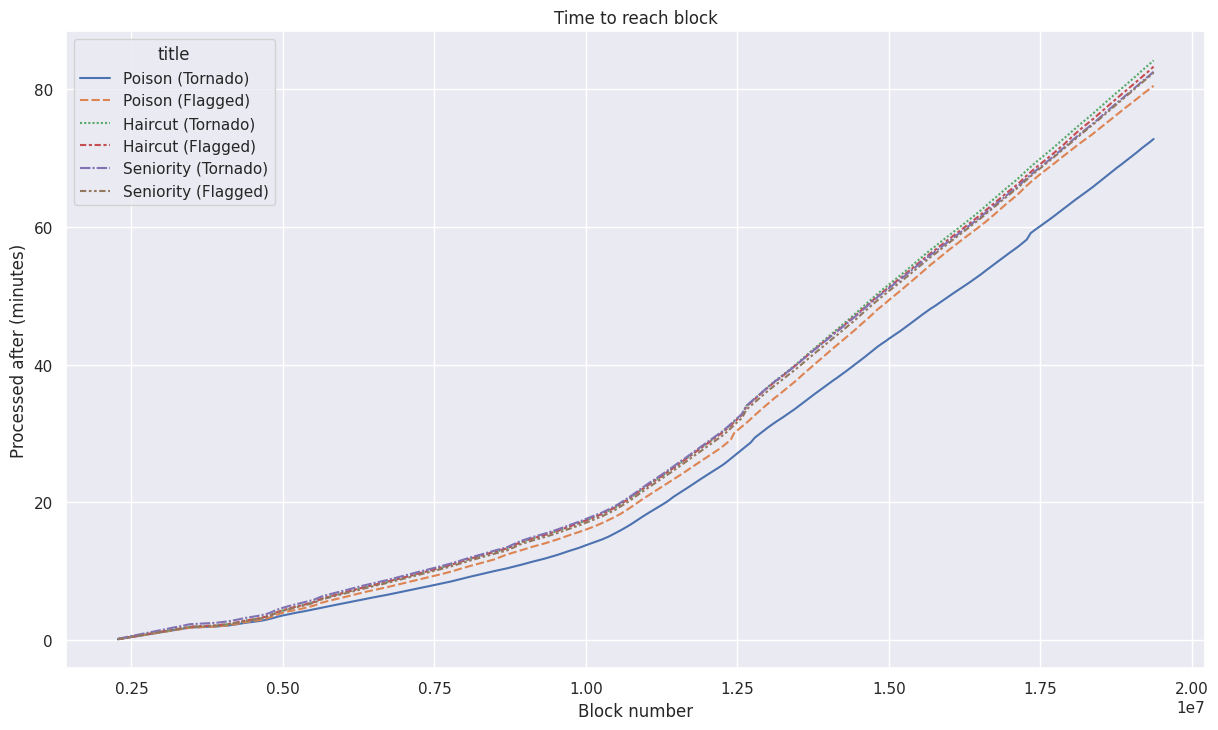

In [54]:
sns.lineplot(x='current_block', y='processed_after_mins', hue='title', style='title', data=rundata).set(title='Time to reach block', xlabel='Block number', ylabel='Processed after (minutes)')

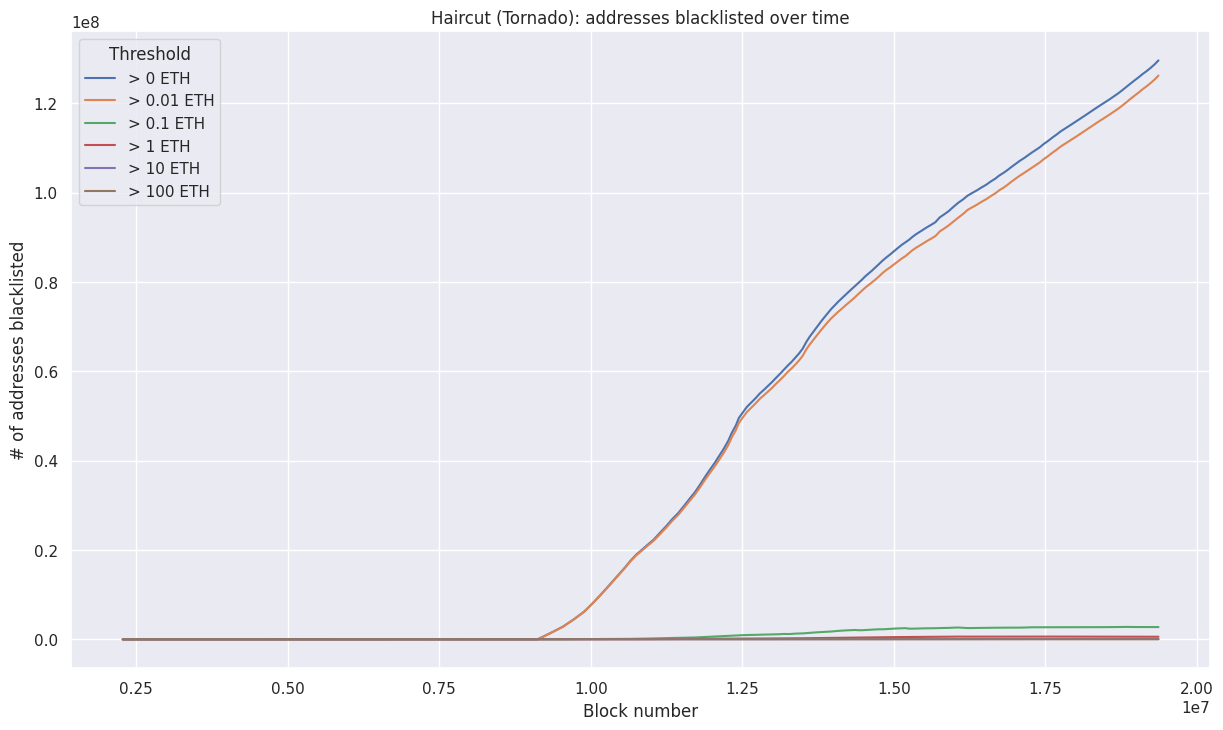

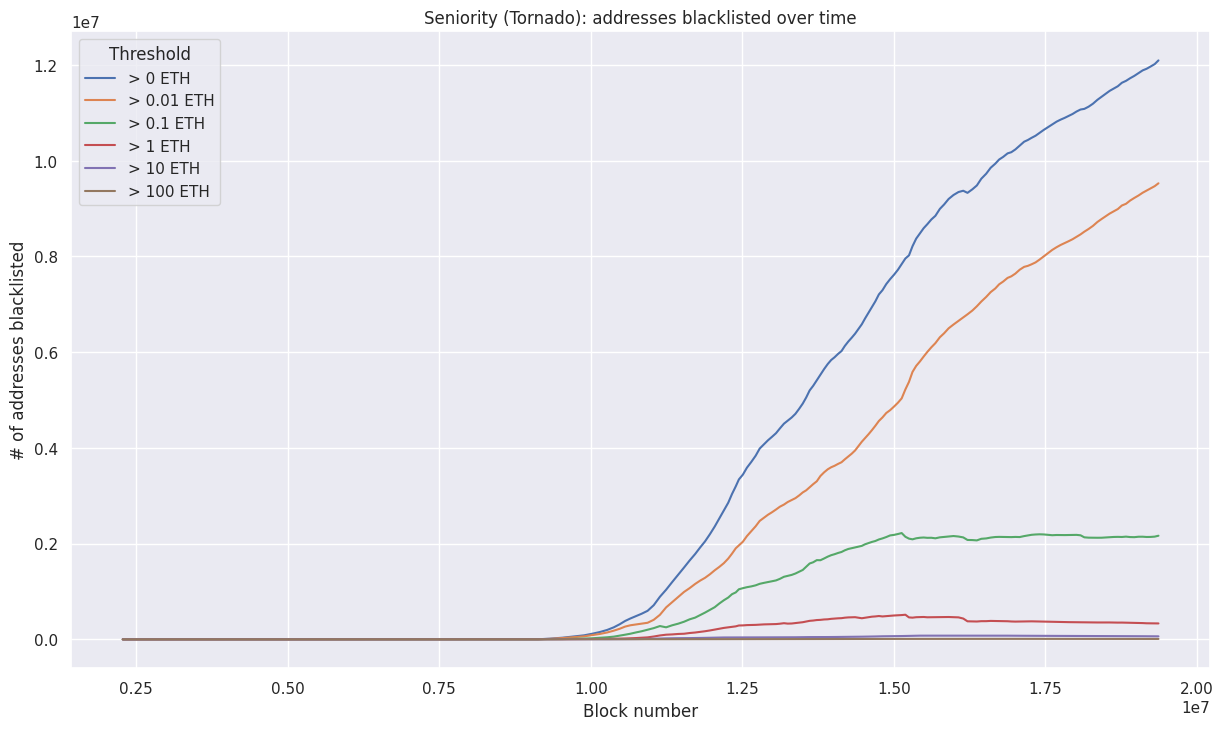

In [56]:
import matplotlib.pyplot as plt


def plot_thresholds(algo, variant):
    threshold_columns = [
        f'n_blacklisted_{str(threshold).replace(".", "_")}'
        for threshold in [0, 0.01, 0.1, 1, 10, 100]
    ]

    filtered_data = rundata[(rundata.algorithm == algo) & (rundata.variant == variant)]
    filtered_data = filtered_data.rename(columns={"n_blacklisted": "n_blacklisted_0"})

    # We need to reshape the data to have 'threshold' as a variable for hue
    melted_data = filtered_data.melt(
        id_vars=["current_block"],
        value_vars=threshold_columns,
        var_name="threshold",
        value_name="n_blacklisted",
    )

    threshold_names = {
        "n_blacklisted_0": "> 0 ETH",
        "n_blacklisted_0_01": "> 0.01 ETH",
        "n_blacklisted_0_1": "> 0.1 ETH",
        "n_blacklisted_1": "> 1 ETH",
        "n_blacklisted_10": "> 10 ETH",
        "n_blacklisted_100": "> 100 ETH",
    }

    # Replace the threshold column with more descriptive names
    melted_data["threshold"] = melted_data["threshold"].map(threshold_names)

    # Plotting all thresholds in one go with hue
    plt.figure(figsize=(14.7, 8.27))
    sns.lineplot(
        data=melted_data, x="current_block", y="n_blacklisted", hue="threshold"
    )

    plt.title(
        f"{algo.capitalize()} ({variant.replace('_', ' ').capitalize()}): addresses blacklisted over time"
    )
    plt.xlabel("Block number")
    plt.ylabel("# of addresses blacklisted")
    plt.legend(title="Threshold")
    plt.show()


plot_thresholds("haircut", "tornado")
plot_thresholds("seniority", "tornado")